<a href="https://colab.research.google.com/github/rodrigoromanguzman/Actividades_Aprendizaje-/blob/main/A1b_DL_TC5033_AD2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [ ]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Get the path to the datasets

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the data

In [ ]:

asl_path = '/content/drive/My Drive/asl_data'
train_df = pd.read_csv(os.path.join(asl_path, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(asl_path, 'sign_mnist_valid.csv'))


In [ ]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

In [ ]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [ ]:
x_train.shape

(27455, 784)

In [ ]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Create a function that will allow you to split the previously loaded validation set
    into valition and test.
    '''
    #We take the index of the images
    idxs = np.arange(x.shape[0])
    if(shuffle):
      #We need to shuffle those indexes
      np.random.shuffle(idxs)
    #We split our data based on the percentage indicated by pct
    #Considering pct to be the percentage of data destinated to validation
    split_point = int(y.shape[0]*pct)
    x_val = x[idxs[:split_point]]
    y_val = y[idxs[:split_point]]
    x_test = x[idxs[split_point:]]
    y_test = y[idxs[split_point:]]
    return x_val,y_val,x_test,y_test


In [ ]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [ ]:
### The following
alphabet=list(string.ascii_lowercase)
print(alphabet)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
24


### Normalise

In [ ]:
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

### Graficar muestras

Sign shown:  p


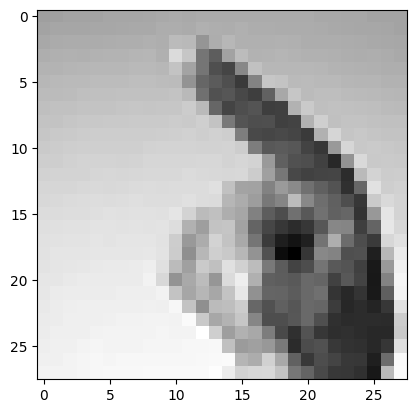

In [ ]:
def showImage(image):
  #The images are already given as one dimensional array
  #So we need to reshape them
  plt.imshow(image.reshape(28,28),cmap=plt.get_cmap('gray'))

#We define a random index for graphing a random instance of the data
randIdx = np.random.randint(y_train.shape[0])
print("Sign shown: ",alphabet[y_train[randIdx]])
showImage(x_train[randIdx].reshape(28,28))

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

In [ ]:
def init_parameters(inputSize,neuronsSizeList):
  parameters = {}
  for i,neuronSize in enumerate(neuronsSizeList):
    if(i == 0):
      # print('CREATING W0 -- neu Size- inputSize')
      # print(neuronSize,inputSize)
      parameters[f'w_{i}'] = np.random.randn(neuronSize,inputSize)*0.1
    else:
      parameters[f'w_{i}'] = np.random.randn(neuronSize,neuronsSizeList[i-1])*0.1

    parameters[f'b_{i}'] = np.zeros((neuronSize,1))
    # print('CREATING b0 -- neu Size- inputSize')
    # print(parameters[f'b_{i}'].shape)
  # print('Init Params')
  # print(parameters)
  return parameters

#### Mini batches

In [ ]:
def createMiniBatches(x,y,shuffled=True,miniBatchSize=50):
  dataSize = y.shape[0]
  idxs = np.arange(dataSize)
  if(shuffled):
    np.random.shuffle(idxs)
  x = x[idxs]
  y = y[idxs]
  return ((x[i:i+miniBatchSize],y[i:i+miniBatchSize])for i in range(0,dataSize,miniBatchSize))

In [ ]:
def reLu(val):
  return np.maximum(0.01 * val, val)

In [ ]:
def computeScores(x,activationFunction,parameters):
  outAZs = {}
  for i in range(len(parameters)//2):
    if(i==0):
      outAZs[f'z_{i}'] =  parameters[f'w_{i}'] @ x.T + parameters[f'b_{i}']
    else:
      outAZs[f'z_{i}'] = parameters[f'w_{i}'] @ outAZs[f'a_{i-1}'] + parameters[f'b_{i}']
    outAZs[f'a_{i}'] = activationFunction(outAZs[f'z_{i}'])
  return outAZs

In [ ]:
def softmax(lastLayerOutput):
  return np.exp(lastLayerOutput)/np.sum(np.exp(lastLayerOutput),axis=0)

In [ ]:
def x_entropy(probabilities, y,batchSize):
  y_prob = probabilities[y.squeeze(),np.arange(y.shape[0])]
  cost = np.sum(-np.log(y_prob))/batchSize
  return cost

In [ ]:
def backwardPass(x,y,parameters,batchSize,computedScores):
  gradients = {}
  #Notice that we start counting layers from 0
  lastLayerIDX = len(parameters)//2 - 1
  scores = computedScores[f'z_{lastLayerIDX}']
  probs = softmax(scores)
  probs[y.squeeze(),np.arange(y.shape[0])] -= 1 # y-hat -y
  for i in range(lastLayerIDX,-1,-1):
    #Compute gradient of last layer
    if(i == lastLayerIDX):
      gradients[f'dz_{i}'] = probs.copy()
      gradients[f'dw_{i}'] = gradients[f'dz_{i}'] @ computedScores[f'a_{i-1}'].T/batchSize
      gradients[f'db_{i}'] = np.sum(gradients[f'dz_{i}'],axis=1, keepdims = True)/batchSize
    else:
      gradients[f'da_{i}'] = parameters[f'w_{i+1}'].T @ gradients[f'dz_{i+1}']
      activatedLayer = gradients[f'da_{i}'].copy()
      activatedLayer[computedScores[f'z_{i}']<=0] = 0
      gradients[f'dz_{i}'] = activatedLayer
      if(i !=0):
        gradients[f'dw_{i}'] = gradients[f'dz_{i}'] @ computedScores[f'a_{i-1}'].T
      else:
        gradients[f'dw_{i}'] = gradients[f'dz_{i}'] @ x
      gradients[f'db_{i}'] = np.sum(gradients[f'dz_{i}'],axis=1, keepdims = True)
  return gradients

In [ ]:
def updateParameters(parameters,learningRate,gradients):
  newParameters = parameters.copy()

  for i in range(len(parameters)//2):
    newParameters[f'w_{i}'] = parameters[f'w_{i}'] - learningRate * gradients[f'dw_{i}']
    newParameters[f'b_{i}'] = parameters[f'b_{i}'] - learningRate * gradients[f'db_{i}']
  return newParameters

In [ ]:
def train(x_train,y_train,batchSize,neuronsSizeList,activationFunction,learningRate,epochs):
  #Initialize the parameters
  parameters = init_parameters(x_train.shape[1],neuronsSizeList)
  #Create the miniBatches
  miniBatches = list(createMiniBatches(x_train,y_train,batchSize))
  for epoch in range(epochs):
    correct = 0
    total = 0
    lastLayerIDX = len(parameters)//2 - 1
    for i , (x,y) in enumerate(miniBatches):
      outAZs = computeScores(x,activationFunction,parameters)
      gradients = backwardPass(x,y,parameters,batchSize,outAZs)
      #Update parameters
      parameters = updateParameters(parameters,learningRate,gradients)
      score = outAZs[f'z_{lastLayerIDX}']
      probabilities = softmax(score)
      correct += np.sum(np.argmax(probabilities,axis=0) == y.squeeze())
      total += probabilities.shape[1]
    accuracy = correct/total
    print(f'Current cost:{x_entropy(probabilities,y,batchSize)}, y accuracy: {accuracy}')
  return parameters


In [ ]:
modelParams = train(x_train,y_train,500,[200,200,200,200,200,len(alphabet)],reLu,0.001,10)

Current cost:0.009711191029387644, y accuracy: 0.2955017301038062
Current cost:0.001554088741453359, y accuracy: 0.56656346749226
Current cost:0.00019804445071154188, y accuracy: 0.7457657985794938
Current cost:0.00012019420783650355, y accuracy: 0.8733928246221089
Current cost:0.0003136132949457799, y accuracy: 0.9194317974867966
Current cost:4.555340914036292e-05, y accuracy: 0.9422691677290111
Current cost:0.0006046311869349464, y accuracy: 0.916955017301038
Current cost:3.3481083997561877e-05, y accuracy: 0.9239118557639774
Current cost:1.3708482021542963e-05, y accuracy: 0.996612638863595
Current cost:7.421330757508878e-06, y accuracy: 0.9999635767619741


In [ ]:
def predict(x, parameters, activationFunction):
    computedScores = computeScores(x, activationFunction, parameters)
    lastLayerIDX = len(parameters) // 2 - 1
    scores = computedScores[f'z_{lastLayerIDX}']
    probabilities = softmax(scores)
    predictions = np.argmax(probabilities, axis=0)
    return predictions

In [ ]:
def evaluate(x_test, y_test, parameters, activationFunction):
    predictions = predict(x_test, parameters, activationFunction)
    accuracy = np.mean(predictions == y_test.squeeze()) * 100
    print(f'Accuracy: {accuracy:.2f}%')

In [ ]:
evaluate(x_test, y_test, modelParams, reLu)

Accuracy: 84.10%


El valor predicho es: a El valor real es: a


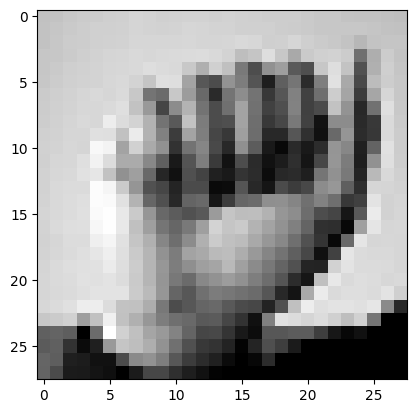

In [ ]:
idx = np.random.randint(len(y_test))
showImage(x_test[idx])

single_example = x_test[idx].reshape(1, -1)

pred = predict(single_example, modelParams, reLu)

pred_label = pred[0]

print(f'El valor predicho es: {alphabet[pred_label]} El valor real es: {alphabet[y_test[idx]]}')